In [371]:
import pandas as pd
import numpy as np

filename = "cars.csv"

dtypes = {
    "maker": str,
    "model": str,
    "mileage": float,
    "manufacture_year": float,
    "engine_displacement": float,
    "engine_power": float,
    "body_type": str,
    "color_slug": str,
    "stk_year": str,
    "transmission": str,
    "door_count": str,
    "seat_count": str,
    "fuel_type": str,
    "date_created": str,
    "date_last_seen": str,
    "price_eur": float}

df = pd.read_csv(filename, dtype=dtypes)
raw_shape = df.shape
print(f"Raw data has {raw_shape[0]} rows, and {raw_shape[1]} columns")
df.head()

Raw data has 3552912 rows, and 16 columns


,maker,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,color_slug,stk_year,transmission,door_count,seat_count,fuel_type,date_created,date_last_seen,price_eur
0,ford,galaxy,151000.0,2011.0,2000.0,103.0,NaN,NaN,None,man,5,7,diesel,2015-11-14 18:10:06.838319+00,2016-01-27 20:40:15.46361+00,10584.75
1,skoda,octavia,143476.0,2012.0,2000.0,81.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.853411+00,2016-01-27 20:40:15.46361+00,8882.31
2,bmw,NaN,97676.0,2010.0,1995.0,85.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.861792+00,2016-01-27 20:40:15.46361+00,12065.06
3,skoda,fabia,111970.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.872313+00,2016-01-27 20:40:15.46361+00,2960.77
4,skoda,fabia,128886.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.880335+00,2016-01-27 20:40:15.46361+00,2738.71


In [372]:
print(df.isna().sum())

maker                   518915
model                  1133361
mileage                 362584
manufacture_year        370578
engine_displacement     743414
engine_power            554877
body_type              1122914
color_slug             3343411
stk_year               1708156
transmission            741630
door_count              614373
seat_count              749489
fuel_type              1847606
date_created                 0
date_last_seen               0
price_eur                    0
dtype: int64


In [373]:
df = df[df['fuel_type'].notna()]
df = pd.get_dummies(df,columns=["fuel_type"])

df = df[df['transmission'].notna()]
df = pd.get_dummies(df,columns=["transmission"])


df = df[df["price_eur"] != 1295.34]

year_of_scepticism = 1970
average_years = df.loc[df["manufacture_year"] >= year_of_scepticism].groupby(["maker", "model"])["manufacture_year"].mean().round().rename("avg_manufacture_year").reset_index()

df = df.merge(average_years, how="left", on=["maker", "model"])
df.loc[df["manufacture_year"] < year_of_scepticism, "manufacture_year"] = np.nan
df["manufacture_year"] = df["manufacture_year"].fillna(df["avg_manufacture_year"])
df = df[df['manufacture_year'].notna()]

# df = df[df['seat_count'].notna()]
# df = df[df['door_count'].notna()]

# features_to_fillna = ["door_count", "seat_count"]
# for feature in features_to_fillna:
#     df[feature] = pd.to_numeric(df[feature], errors="coerce") # transform to numeric
#     replace_with = df[feature].median()                       # deduce the median
#     df[feature].fillna(replace_with,inplace=True)             # replace null

# df["seat_str"] = np.select(
#     condlist=[
#         (df["seat_count"] >= 0) & (df["seat_count"] < 4),
#         (df["seat_count"] >= 4) & (df["seat_count"] < 6),
#         (df["seat_count"] >= 6)],
#     choicelist=[
#         "small",
#         "medium",
#         "large",
#         ],
#     default="unknown")
# df = pd.get_dummies(df,columns=["seat_str"])
df = df.drop(["seat_count"], axis=1)
df = df.drop(["door_count"], axis=1)


features_to_fillna = ["mileage", "engine_displacement", "engine_power",]
for feature in features_to_fillna:
    replace_with = df[feature].mean() # deduce the mean
    # replace_with = df[feature].median() # deduce the median 
    # replace_with = df[feature].mode() # deduce the mode
    df[feature].fillna(replace_with,inplace=True)
    
# let's transform str dates in datetimes and creare a new feature with the duration of the ad
df['date_created'] = pd.to_datetime(df['date_created']).dt.normalize()
df['date_last_seen'] = pd.to_datetime(df['date_last_seen']).dt.normalize()
df['ad_duration'] = (df['date_last_seen'] - df['date_created']).dt.days # new feature: how much last the ad

features_to_drop = ["model", "body_type", "color_slug", "stk_year", "avg_manufacture_year"]
df = df.drop(features_to_drop, axis="columns")

In [374]:
# df = df.head(200000)

In [375]:
features_to_drop = ["date_created", "date_last_seen"]
df = df.drop(features_to_drop, axis="columns")

df_with_maker = df[df['maker'].notna()]
df_with_maker.info(null_counts=True)

df_no_maker = df[df['maker'].isna()]
df_no_maker.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 790993 entries, 0 to 1110504
Data columns (total 14 columns):
maker                  790993 non-null object
mileage                790993 non-null float64
manufacture_year       790993 non-null float64
engine_displacement    790993 non-null float64
engine_power           790993 non-null float64
price_eur              790993 non-null float64
fuel_type_cng          790993 non-null uint8
fuel_type_diesel       790993 non-null uint8
fuel_type_electric     790993 non-null uint8
fuel_type_gasoline     790993 non-null uint8
fuel_type_lpg          790993 non-null uint8
transmission_auto      790993 non-null uint8
transmission_man       790993 non-null uint8
ad_duration            790993 non-null int64
dtypes: float64(5), int64(1), object(1), uint8(7)
memory usage: 53.6+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 277767 entries, 9 to 1110501
Data columns (total 14 columns):
maker                  0 non-null object
mileage              

In [376]:
from sklearn.model_selection import train_test_split

X = df_with_maker.drop("maker", axis=1).values
Y = df_with_maker["maker"].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

ACCURACY: TRAIN=0.9355 TEST=0.8759
[2, 3, 4, 1, 0, 12, 6, 8, 10, 11, 9, 7, 5]
Feature ranking:
1. feature 2 (0.4017854404004823)
2. feature 3 (0.2459316212288798)
3. feature 4 (0.11190627780785618)
4. feature 1 (0.08242702617032333)
5. feature 0 (0.0716375827869131)
6. feature 12 (0.031530694091909485)
7. feature 6 (0.01860652212202331)
8. feature 8 (0.01828897283725386)
9. feature 10 (0.009450485677221149)
10. feature 11 (0.00843537687713734)
11. feature 9 (0.0)
12. feature 7 (0.0)
13. feature 5 (0.0)


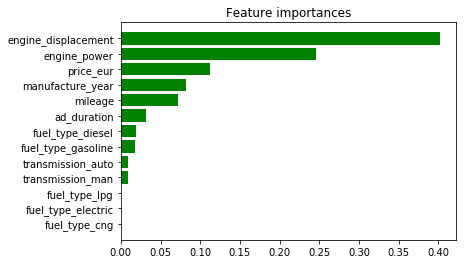

In [377]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

%matplotlib inline

forest = RandomForestClassifier(n_estimators=35, max_depth=25, random_state=False, max_features=0.6, min_samples_leaf=3)

forest.fit(X_train, Y_train)

y_pred_train = forest.predict(X_train)
y_pred = forest.predict(X_test)

accuracy_train = accuracy_score(Y_train, y_pred_train)
accuracy_test = accuracy_score(Y_test, y_pred)

print("ACCURACY: TRAIN=%.4f TEST=%.4f" % (accuracy_train,accuracy_test))

importances = forest.feature_importances_
indices = list(np.argsort(importances))[::-1]
print(indices)

print("Feature ranking:")
for count, f in enumerate(indices):
    print("{0}. feature {1} ({2})".format(count+1, f, importances[f]))

plt.title("Feature importances")
plt.barh(range(len(indices)), importances[indices], color="g", align="center")
plt.yticks(range(len(indices)), df_with_maker.iloc[:, 1:].columns[indices])
# plt.ylim([-1, len(indices)])
plt.gca().invert_yaxis()

##ACCURACY: TRAIN=0.9378 TEST=0.8853

In [378]:
df_no_maker = df_no_maker.drop('maker', axis=1)
prediction = forest.predict(df_no_maker)

df_no_maker.insert(0, 'maker', prediction)

frames = [df_with_maker, df_no_maker]
df = pd.concat(frames)
df

,maker,mileage,manufacture_year,engine_displacement,engine_power,price_eur,fuel_type_cng,fuel_type_diesel,fuel_type_electric,fuel_type_gasoline,fuel_type_lpg,transmission_auto,transmission_man,ad_duration
0,ford,151000.0,2011.0,2000.000000,103.0,10584.75,0,1,0,0,0,0,1,74
1,skoda,143476.0,2012.0,2000.000000,81.0,8882.31,0,1,0,0,0,0,1,74
2,bmw,97676.0,2010.0,1995.000000,85.0,12065.06,0,1,0,0,0,0,1,74
3,skoda,111970.0,2004.0,1200.000000,47.0,2960.77,0,0,0,1,0,0,1,74
4,skoda,128886.0,2004.0,1200.000000,47.0,2738.71,0,0,0,1,0,0,1,74
5,skoda,140932.0,2003.0,1200.000000,40.0,1628.42,0,0,0,1,0,0,1,74
6,skoda,167220.0,2001.0,1400.000000,74.0,2072.54,0,0,0,1,0,0,1,74
7,bmw,148500.0,2009.0,2000.000000,130.0,10547.74,0,1,0,0,0,1,0,74
8,skoda,105389.0,2003.0,1900.000000,81.0,4293.12,0,1,0,0,0,0,1,74
13,skoda,41250.0,1990.0,1300.000000,44.0,370.10,0,0,0,1,0,0,1,74


In [379]:
df_exper = df.copy()

In [395]:
df_final = pd.get_dummies(df,columns=["maker"])
#df_final = df.drop("maker", axis=1)

In [396]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = df_final.drop("price_eur", axis=1).values
Y = df_final["price_eur"].values

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=0)


ll = LinearRegression()
ll.fit(X_train, Y_train)
Y_pred = ll.predict(X_test)

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))

MSE: 5617517630.488908
R2 score: 0.03223033235495154


In [397]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = df_final.drop("price_eur", axis=1).values
Y = np.log1p(df_final["price_eur"].values)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=0)


ll = LinearRegression()
ll.fit(X_train, Y_train)
Y_pred = ll.predict(X_test)

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))
#R2 score: 0.6795536625857681
df_final.shape[0]

MSE: 0.29587032624926235
R2 score: 0.7110370941286682


1068760

In [390]:
# from scipy import stats

# df_final = df_final\
#     .loc[:, lambda df: df.std() > 0.05].loc[lambda df: (np.abs(stats.zscore(df)) < 3).all(axis=1)]

# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score

# X = df_final.drop("price_eur", axis=1).values
# Y = np.log1p(df_final["price_eur"].values)

# X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=0)


# ll = LinearRegression()
# ll.fit(X_train, Y_train)
# Y_pred = ll.predict(X_test)

# print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
# print("R2 score: "+str(r2_score(Y_test, Y_pred)))
# #R2 score: 0.8128178642159138
# df_final.shape[0]

MSE: 0.14648942065363832
R2 score: 0.8274344855828581


373996

In [391]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373996 entries, 1 to 1110499
Data columns (total 37 columns):
mileage                373996 non-null float64
manufacture_year       373996 non-null float64
engine_displacement    373996 non-null float64
engine_power           373996 non-null float64
price_eur              373996 non-null float64
fuel_type_diesel       373996 non-null uint8
fuel_type_gasoline     373996 non-null uint8
transmission_auto      373996 non-null uint8
transmission_man       373996 non-null uint8
ad_duration            373996 non-null int64
maker_audi             373996 non-null uint8
maker_bmw              373996 non-null uint8
maker_chevrolet        373996 non-null uint8
maker_citroen          373996 non-null uint8
maker_fiat             373996 non-null uint8
maker_ford             373996 non-null uint8
maker_honda            373996 non-null uint8
maker_hyundai          373996 non-null uint8
maker_jaguar           373996 non-null uint8
maker_jeep             

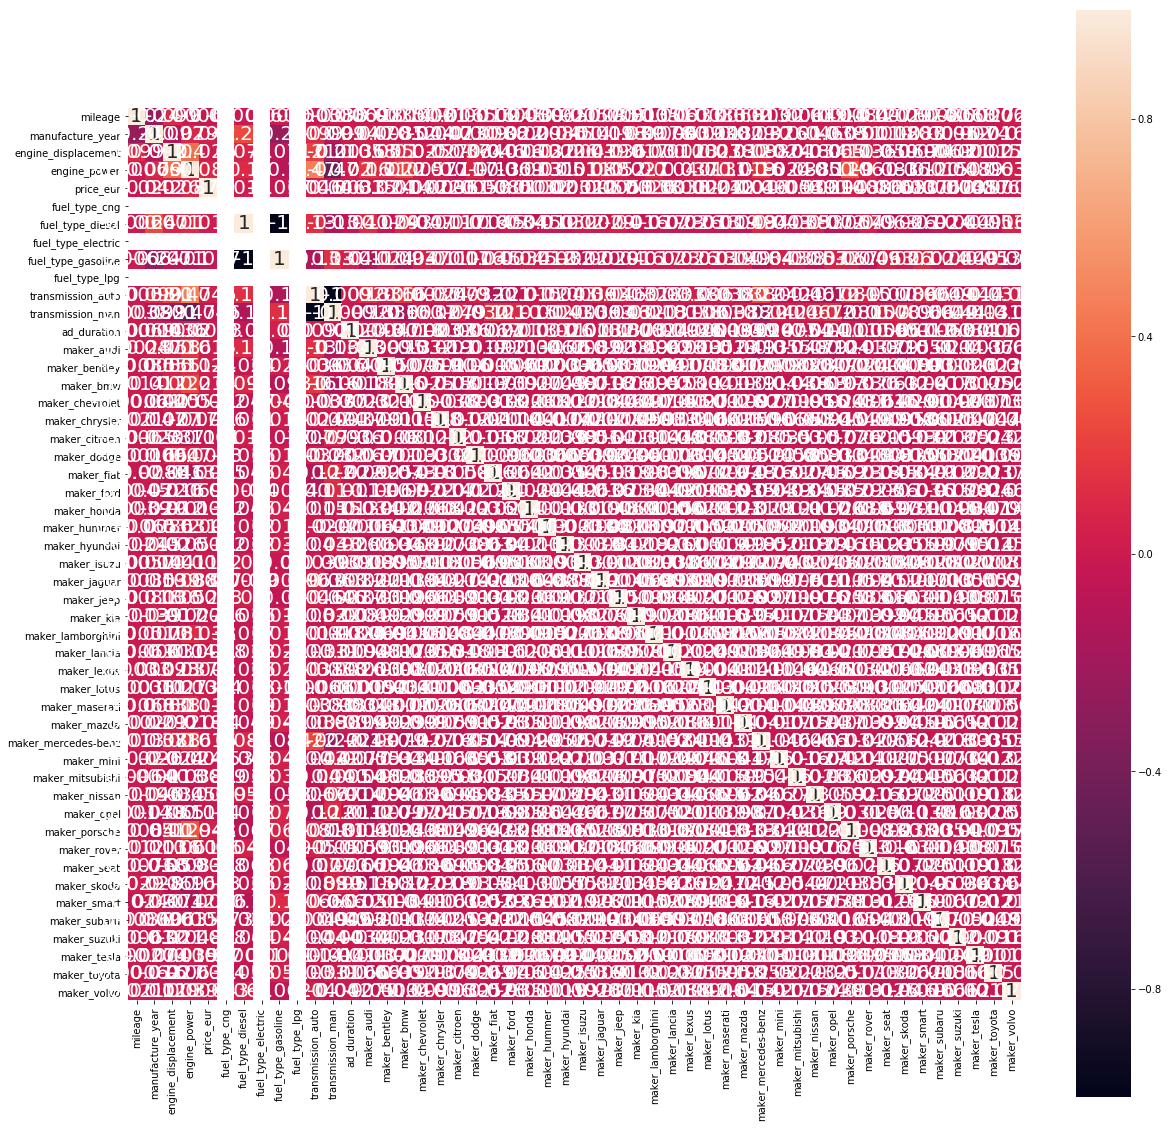

In [398]:
import seaborn as sns

#cols=['RM',"ZN","LSTAT","PRATIO","TAX","INDUS","MEDV"]

plt.figure(figsize = (20,20))
hm = sns.heatmap(df_final.corr(),
                 cbar=True,
                 square=True,
                 yticklabels=df_final.columns,
                 xticklabels=df_final.columns,
                 annot=True,                          #Questo ci mostra i valori degli indici
                 annot_kws={'size':20}
                )               #Impostiamo la dimensione dell'annotazione a 12 per farla entrare dentro il quadrato

plt.show()

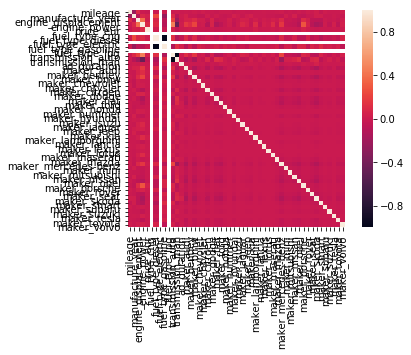

In [399]:
import seaborn as sns

#sns.set(font_scale=1.5)
hm = sns.heatmap(df_final.corr(),
                 cbar=True, #disegna una barra con l'intensità del colore
                 square=True, #forza le caselle a una dimensione quadrata
                 yticklabels=df_final.columns, #labels per i valori sull'asse Y
                 xticklabels=df_final.columns) #labels per i valori sull'asse X
plt.show()